<img src="https://drive.google.com/uc?export=view&id=1x-QAgitB-S5rxGGDqxsJ299ZQTfYtOhb" width=180, align="center"/>

Master's degree in Intelligent Systems

Subject: 11754 - Deep Learning

Year: 2022-2023

Professor: Miguel Ángel Calafat Torrens


# Lab 4.2 - CNN and transfer learning

## CNN

In general, when the images are not as well prepared as the MNIST database, it is not usual to use neural networks composed only of dense layers for classification. A more powerful method like convolutional networks is needed.

Everything you've seen so far about training and recording models applies whether or not the model has convolutional layers. As you have seen in the theory of the course, a convolution is a mathematical transformation that, to some extent, represents the amount of overlap between two tensors as one moves over the other.

From the point of view of graphic pattern identification, this operation preserves much more information on the relationship between pixels than what has been done so far with dense layers. On the other hand, from the point of view of the pytorch user it is simply one more layer, whose parameters must be entered based on what you want to do.

In the following image you can see what would be the treatment of a single image with two convolutional layers followed by maxpool layers. This is just a conceptual example to understand what happens dimensionally to the input tensor until it reaches the output. This example applies an arbitrary number of filters and a factor 2 reduction in height and width when applying the maxpool layers.

<img src="https://drive.google.com/uc?export=view&id=1CJSpntUztXf78hPQI_QkHbuZaEIkdPYI" width=1800>

On this occasion we will use the dataset by _Ajayi, Gbeminiyi (2018), “Multi-class Weather Dataset for Image Classification”, Mendeley Data, V1, doi: 10.17632/4drtyfjtfy.1_, which you can find in its original format [here]( https://data.mendeley.com/datasets/4drtyfjtfy/1?ref=hackernoon.com), licensed under [here](https://creativecommons.org/licenses/by/4.0/)

In this dataset there are images of 4 different situations: image of a cloudy day (cloudy), of a rainy day (rain), of a sun shiny (shine) and images of dawn (sunrise).

This _dataset_ will be used with the pytorch _ImageFolder_ object. Therefore, it is convenient that you first do a brief pre-treatment of the folder structure. You will see that the downloaded file, after unzipping it, leaves all the images together in the same folder. You can distinguish the type of image by its name (they are all named after the name of the class they represent plus an order number. For example: cloudy25, rain108, shine2, sunrise50)

Before you upload your images to your Drive, you'll need to organize them as follows. You will have the main folder that will contain this data with the name _weather_images_. Inside this folder there will be 4 subfolders with the following names: cloudy, rain, shine, sunrise. Within each of these subfolders will be all the images of its type.

Once you have this structure, delete the _rain141.jpg_ and _shine131.jpg_ files, as they are corrupted. Load this folder structure in your Drive, in the same location where you have this .ipynb file.

In [ ]:
# Connect to your drive
from google.colab import drive, files
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/Colab Notebooks/'
%ls -l

# Here the path of the project folder (which is where this file is) is inserted
# into the python path.
import pathlib
import sys

PROJECT_DIR = str(pathlib.Path().resolve())
sys.path.append(PROJECT_DIR)

**Important:** This notebook will make use of the _test_ function that you completed at the end of practice 4.1. Edit the help file _helper_PR4_2.py_ and paste the function there.

### Data transformation and augmentation

In practice with MNIST a transformation was applied to the images that was simply based on converting them into a tensor. It is very common in image processing to use techniques to increase the database. For example, let's imagine that we want to train a network with images of cars; but all the images show the cars seen from the side with the front on the left and the rear on the right. If we train our network in this way, it will be unable to identify a vehicle that is facing the other way. With this in mind, it is normal that a series of transformations are applied to the original set of images in order to increase the data and that the network can better generalize.

Thus, for example, it could be normal to resize the image and select a random patch (so that what is important in the image is not always well centered), or it could be inverted about a vertical or horizontal axis, or it could be rotated with a random angle. The values could also be normalized based on means and standard deviations of the intensity values. Check all the possibilities [here](https://pytorch.org/vision/stable/transforms.html?highlight=transforms)

In [11]:
# Import libraries
import os
from torchvision import datasets, models
import torchvision.transforms as transforms
from torch.utils.data import random_split, Dataset
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import time
import copy
from PIL import Image
import cv2
import helper_PR4 as hp
from glob import glob
import random
from imutils import paths
from typing import List

In [7]:
# Global variables and setup
SEED = 0
IMG_FOLDER = PROJECT_DIR + "/weather_images"

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

VALID_SIZE = 0.2
TEST_SIZE = 0.2

print('Using {}'.format(DEVICE))
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

Using cuda


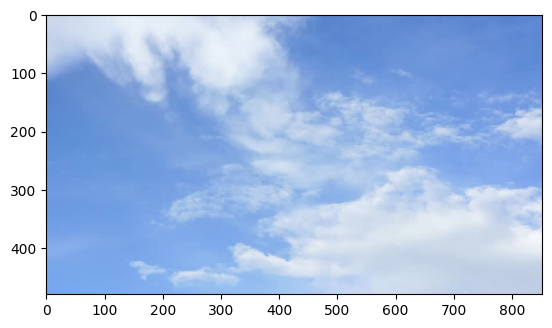

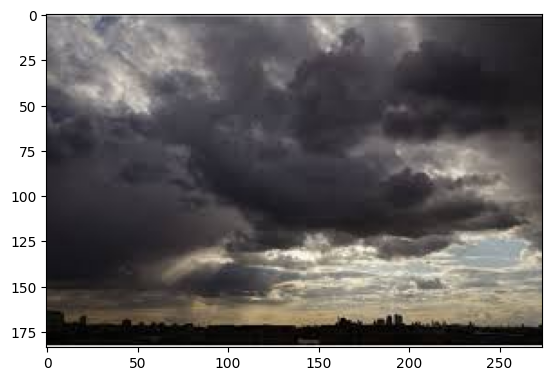

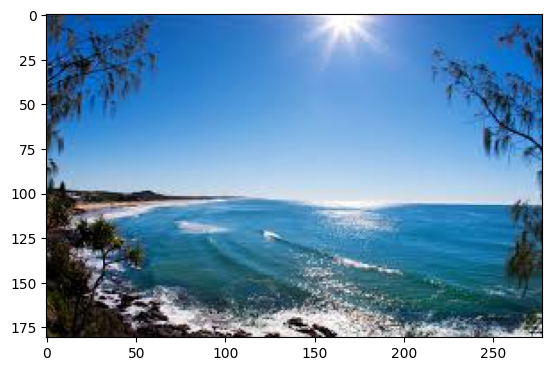

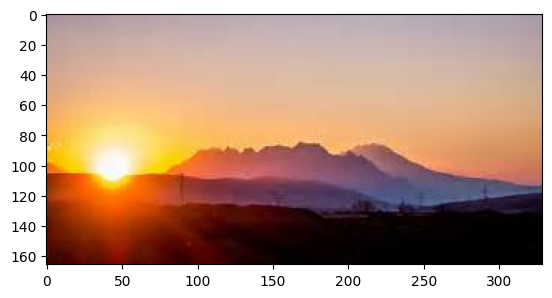

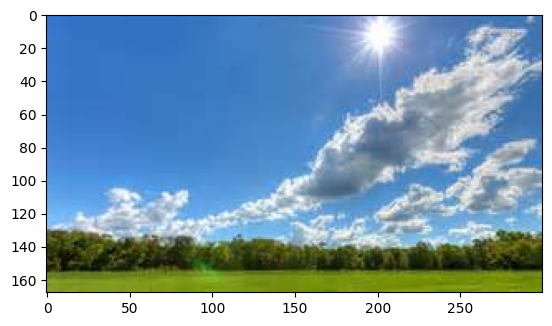

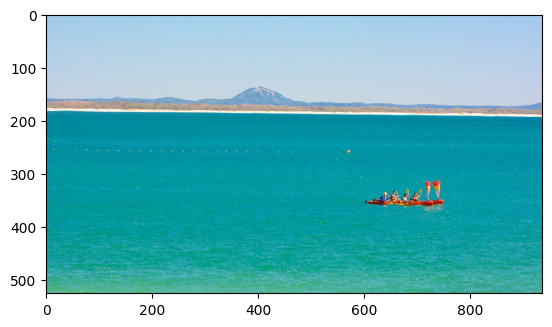

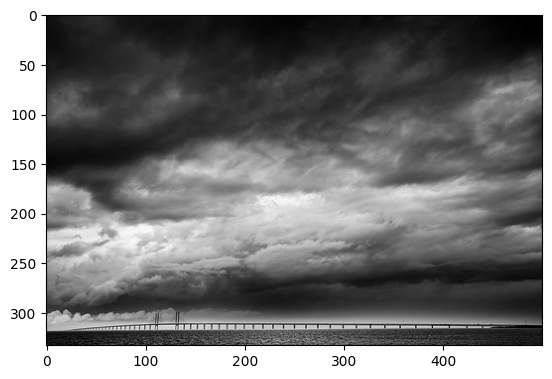

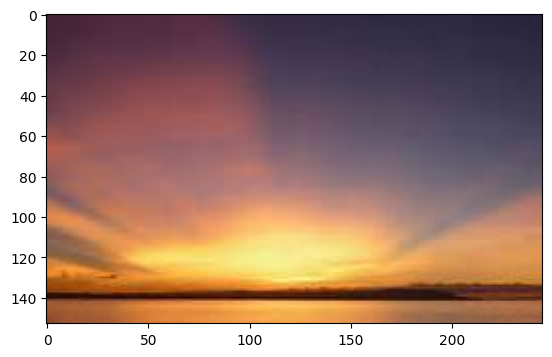

In [8]:
# Let's check some images
image_path_array = random.choices(np.array(glob(IMG_FOLDER + "/*/*")), k=8)

for image in image_path_array:

    # Read jpg image H x W x D (values between 0 and 255)
    img = cv2.imread(image)

    # Convert to RGB and show it
    rgb_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb_image)
    plt.show()

In [9]:
# Let's analyze what we have
# Notice that the images have different dimensions
# In addition, the images have the format H x W x D
# (Height x Width x Depth) = (height x width x 3)
print('One image shape: {}'.format(rgb_image.shape))
print('Number of images: {}'.format(len(np.array(glob(IMG_FOLDER + "/*/*")))))

One image shape: (153, 245, 3)
Number of images: 1123


In [10]:
# The first thing to consider are the transformations to be applied to the
# training dataset. Since the images have different dimensions, we will choose
# fixed dimensions to work with, so that one of the transformations to be
# carried out has to be a resizing and/or a crop.

# Another transformation is normalization. In this case, we apply mean and
# standard deviation values that are specific to this dataset, and which have
# been obtained by loading all the images and calculating the mean and standard
# deviation of each channel. That is: You would put the entire dataset in a
# tensor of shape b x H x W x D, and apply:
# calc_mean = tensor.mean(axis=(0, 1, 2))
# calc_std = tensor.std(axis=(0, 1, 2))

# If you did not know these values, possibly values of mean between 0.45 and
# 0.5, and values of sd close to 0.25 are usually reasonable.


# Normalization values
dt_mean = (0.4919, 0.4798, 0.4642)
dt_std = (0.2655, 0.2441, 0.2893)
normalizer = transforms.Normalize(mean=dt_mean, std=dt_std)

# The composition of transformations is applied to each set.
# In the training we do rotations, crops and flips. We leave the final
# dimensions at 224 x 224
train_transform = transforms.Compose([transforms.RandomRotation(degrees=10),
                                      transforms.Resize((264, 264)),
                                      transforms.RandomCrop((224, 224)),
                                      transforms.RandomHorizontalFlip(p=0.2),
                                      transforms.ToTensor(),
                                      normalizer])

# In validation and testing, it is not necessary to subject the system to so
# many transformations. After all, it is about seeing the response of the model
# to real images
valid_transform = transforms.Compose([transforms.Resize((264, 264)),
                                      transforms.CenterCrop((224, 224)),
                                      transforms.ToTensor(),
                                      normalizer])

test_transform = transforms.Compose([transforms.Resize((264, 264)),
                                     transforms.CenterCrop((224, 224)),
                                     transforms.ToTensor(),
                                     normalizer])

It is time to define the dataset object. For this, given the configuration we have of the image directory, a dataset of the type [ImageFolder](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html#imagefolder) will be used.

In this part, I use my CustomDataset class instead of ImageFolder. 

In [96]:
# Define new class Dataset specific for this project
class CustomDataset(Dataset):
    def __init__(self, im_paths, transform=None):
        self.image_paths = im_paths  # List of paths as strings
        self.transform = transform  # Transformations
        self.classes = sorted(set([self.get_label(path) for path in im_paths]))  # Unique labels as strings
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}  # Dictionary mapping classes to indexes. For
                                  # example: {'cloudy':0, `rain`:1, ...}
        self.labels = [self.class_to_idx[self.get_label(path)] for path in im_paths]
        # List of integers with labels corresponding to the
                            # list of paths (image_paths)


    def __len__(self):
        # Don't do anything in this function. It is provided for you
        return len(self.labels)


    def __getitem__(self, idx):
        # Do all the necessary treatment of data. Remember that when you apply
        # next() to the daloader, it will call this function. So you have to
        # do all the necessary steps to deliver the image and the label.

        # You don't have to worry about the batch; it's controlled by the
        # dataloader. You just have to return an image and label pointed by
        # an index (idx)
        
        path = self.image_paths[idx]
        image = Image.open(path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform is not None:
            image = self.transform(image)
        
        return image, torch.tensor(label)

    def get_label(self, path):
        """
        Returns the label of an image, which is the string of characters
        in the filename until the first digit is found.
        """
        filename = path.split('/')[-1]  # get the filename from the path
        label = ''
        for char in filename:
            if char.isdigit():
                break
            label += char
        return label

Here, I define full_dataset with CustomDataset class.

In [97]:
img_paths = glob(os.path.join(IMG_FOLDER + "/*/*"))
full_dataset = CustomDataset(img_paths,test_transform)
print(type(full_dataset))

<class '__main__.CustomDataset'>


In [98]:
# We define the dataset with the test transformations (in principle)
#full_dataset = datasets.ImageFolder(IMG_FOLDER, transform=test_transform)
#print(type(full_dataset))

In [99]:
# We randomly separate 20% of the training samples to use for validation, and
# another 20% for testing.
n_valid = round(0.2 * len(full_dataset))
n_test = n_valid
n_train = len(full_dataset) - n_valid - n_test
train_dataset, valid_dataset, test_dataset = random_split(full_dataset,
                                                 [n_train, n_valid, n_test])

In [100]:
# We see what type of object we have and how the original dataset has
# been distributed
print(type(train_dataset))
print(len(train_dataset))
print(len(valid_dataset))
print(len(test_dataset))

<class 'torch.utils.data.dataset.Subset'>
673
225
225


Notice that in this case we have an object of type subset. If we want to apply different transformations to the training and validation subset, we must be careful. Both subsets share the reference to the transformations that you defined when you downloaded the original dataset (referenced in the dataset's .transform attribute), so that if you modify it for the training subset it remains modified for the validation subset and vice versa.
The only thing you will have to do to alleviate this small inconvenience is to take the precaution of unlinking the transformations of one and the other dataset.

In [101]:
# Train_data is unlinked from full_dataset, in order to be able to apply other
# transformations different from those indicated there
train_dataset = copy.deepcopy(train_dataset)

In [102]:
# The transformations to apply to the training dataset are selected
train_dataset.dataset.transform = train_transform

In [103]:
# Check that both transformations do not refer to the same thing
print(train_dataset.dataset.transform is valid_dataset.dataset.transform)
# however, the validation and test ones remain the same
print(valid_dataset.dataset.transform is test_dataset.dataset.transform)

False
True


In [104]:
# Number of parallel processes
num_workers = 2

# Number of images in one batch
batch_size = 64

# Dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=num_workers)

valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=num_workers)

In [105]:
# Let's chek the format of the dataloader output
data_iter = iter(train_loader)
images, labels = next(data_iter)
print('Batch shape: {}'.format(images.data.shape))
print('Image shape: {}'.format(images.data[0].shape))
print('Minimum image value: {}'.format(images.data[0].min()))
print('Maximum image value: {}'.format(images.data[0].max()))
print('Batch means: {}'.format(images.data.mean(axis=(0,2,3))))
print('Batch std: {}'.format(images.data.std(axis=(0,2,3))))

Batch shape: torch.Size([64, 3, 224, 224])
Image shape: torch.Size([3, 224, 224])
Minimum image value: -1.9655877351760864
Maximum image value: 2.131093740463257
Batch means: tensor([-0.0218, -0.0631, -0.0279])
Batch std: tensor([1.0636, 1.0539, 1.0303])


In [106]:
# The images are provided as a tensor of as many positions as the defined batch,
# and then a tensor of 3 x 224 x 224. This is different from how they looked as
# they were loaded from the dataset. At that time, in numpy, the images were
# H x W x 3, which indicates that the transformations, although specified at
# dataset download time, are actually applied when "next()"" is called on the
# dataloader iterator.

# (b x D x H x W) = (batch x Depth x Height x Width) = (b x 3 x 224 x 224)
print(images.shape)
print(labels.shape)

torch.Size([64, 3, 224, 224])
torch.Size([64])


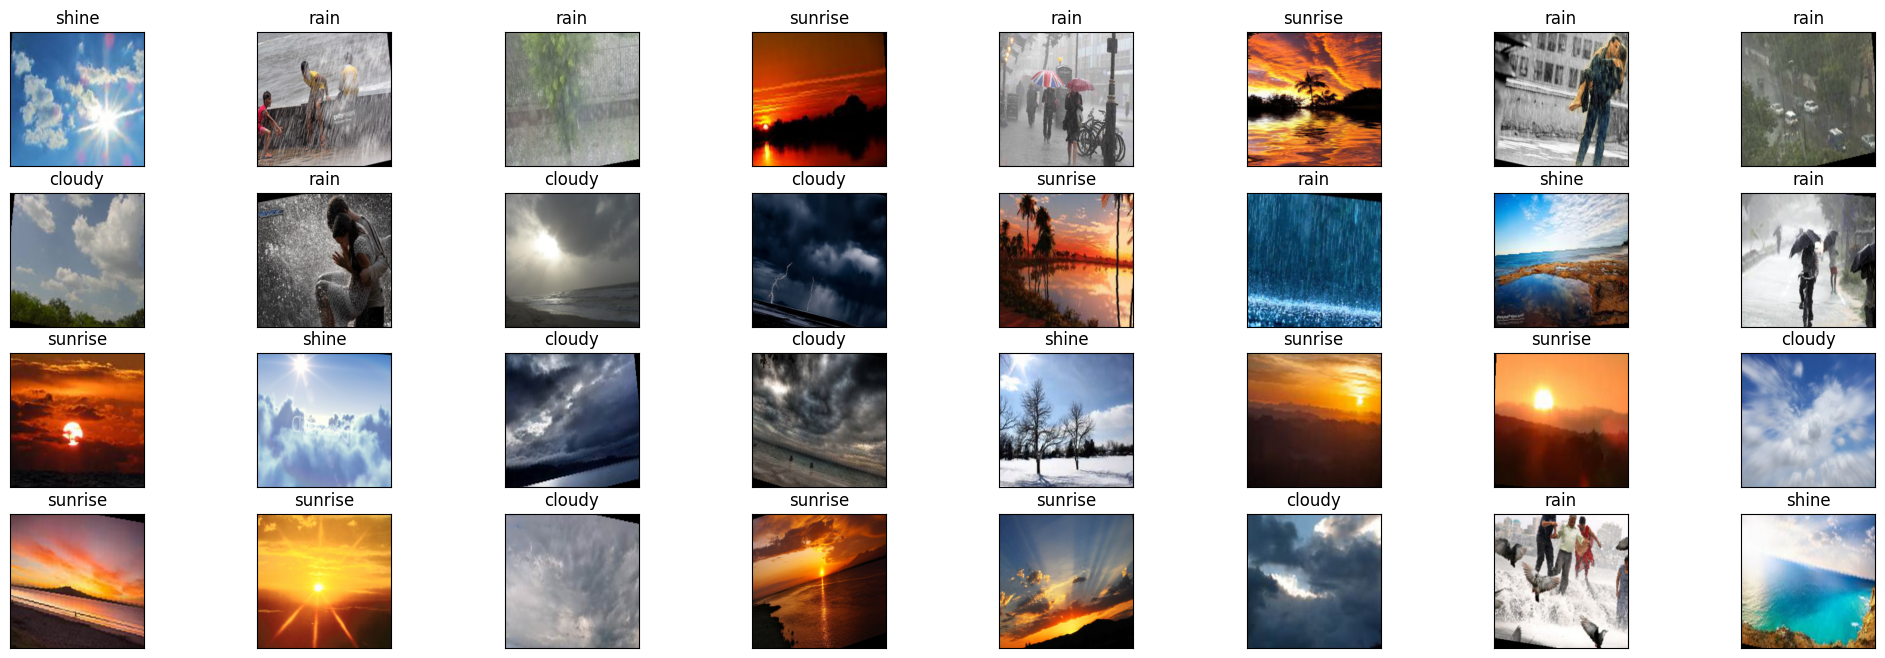

In [107]:
# Let's look at some of those images. Observe how in some the applied rotation
# is perceived
fig = plt.figure(figsize=(25, 8))
bs = 32 if batch_size > 32 else batch_size
for k in range(bs):
    ax = fig.add_subplot(int(np.ceil(bs / 8)), 8, k + 1, xticks=[], yticks=[])
    # From torch tensor to np-array
    img = images[k].numpy()
    # Denormalizes to see the original color
    for n in range(len(dt_std)): img[n] = img[n] * dt_std[n] + dt_mean[n]
    # Transposed so that the color channels are the last dimension
    ax.imshow(np.transpose(img, (1, 2, 0)))

    # The correct label is included on each image
    ax.set_title(train_loader.dataset.dataset.classes[labels[k].item()])

### Model definition

We are going to use in this model three blocks of convolutional layer, followed by activation with ReLU and finally followed by a Maxpool layer. After these three blocks we will apply a classifier with two dense layers that will give us the value of the 4 possible classifications. Also, instead of using CrossEntropyLoss for losses we will use NLLLoss. This implies that in the output we will put an activation of the LogSoftmax type instead of directly taking the _logits_. See the details of [NLLLoss here](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html).

Let's look at the most important parameters of the convolution and maxpool layers.

[nn.Conv2d](https://pytorch.org/docs/1.9.1/generated/torch.nn.Conv2d.html)  --> self.convolution = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
* ```in_channels``` are the input channels; that is, the depth of the image. In this case, having color images, they have a depth of 3 in the first layer.
* ```out_channels``` is the output depth; that is, the number of filters to apply to the input. Here we can put what we consider appropriate.
* ```kernel_size``` indicates the dimensions of the filters. It can be an integer (square filters) or a tuple. It is usually convenient that the filters are not very large.
* ```stride``` is the forward step of the convolution.
* ```padding``` indicates the thickness (in pixels) with which the original image will be framed when applying the convolution

You may have already noticed that some of these parameters influence the dimensions of the output. A perfectly valid option is to set ```padding='same'```. This implies that the necessary ```padding``` will be selected to make the output dimensions (height and width) equal to the input dimensions. This is only applicable with ```stride=1```.

[nn.MaxPool2d](https://pytorch.org/docs/1.9.1/generated/torch.nn.MaxPool2d.html?highlight=maxpool#torch.nn.MaxPool2d)  --> self.maxpool = nn.MaxPool2d(kernel_size, stride)
* ```kernel_size``` is the size of the window to which the maximum will apply
* ```stride``` is the step that is applied to the window. If nothing is set, it is considered by default equal to ```kernel_size```

In [108]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        # nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # 16 filters of shape 3x3 are selected in this first layer and the
        # values are fixed so that the dimensions are not altered
        self.conv1 = nn.Conv2d( 3, 16, kernel_size=3, stride=1, padding=1)
        # In the second layer we apply 32 filters. Note that the input must
        # have the dimensions of the previous output
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        # In the third layer we apply 64 filters
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # We define a maxpool layer with a window of 2x2 and a step of 2
        self.maxpool = nn.MaxPool2d(2)
        
        # We define the dropout layer that will be used to avoid overfitting
        self.dropout = nn.Dropout(p=0.3)
        
        # We define the final activation layer to use with NLLLoss
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
        # The classifier. The classifier is the final part of the network.
        # Everything that comes out of the convolutions is put given to the
        # The output will consist of as many units as classes we want to
        # classify.
        # In order to properly define the input units of the classifier, you
        # need to know what dimensional treatment you have done to the images.
        # In this case, the images have entered the model with dimensions of
        # 3 x 224 x 224 and will come out of the convolutional layers with
        # dimensions of 64 x 28 x 28 (see details in the forward pass).
        
        # First layer of the classifier with 512 starts
        self.fc1 = nn.Linear(64 * 28 * 28, 512)
        # Second layer of the classifier with the outputs to classify
        self.fc2 = nn.Linear(512, 4)


    def forward(self, x):
        # Block 1
        # Convolution and relu
        # In: b x 3 x 224 x 224  Out: b x 16 x 224 x 224
        x = F.relu(self.conv1(x))
        # Maxpool
        # In: b x 16 x 224 x 224  Out: b x 16 x 112 x 112
        x = self.maxpool(x)
        
        # Block 2
        # Convolution, relu and maxpool
        # In: b x 16 x 112 x 112  Out: b x 32 x 56 x 56
        x = self.maxpool(F.relu(self.conv2(x)))
        
        # Block 3
        # Convolution, relu and maxpool
        # In: b x 32 x 56 x 56  Out: b x 64 x 28 x 28
        x = self.maxpool(F.relu(self.conv3(x)))

        # Flatten the outputs to give them to the classifier
        # In: b x 50176
        x = x.reshape(-1, 64 * 28 * 28)
        # Add a dropout layer
        x = self.dropout(x)
        # And go into the classifier's first layer
        # In: b x 50176  Out: b x 512
        x = F.relu(self.fc1(x))
        # And finally the second stage of the classifier with its activation
        # In: b x 512  Out: b x 4
        x = self.logsoftmax(self.fc2(x))
        return x

In [109]:
# Instantiate the model
model = CNN()
print(model)

model = model.to(DEVICE)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (logsoftmax): LogSoftmax(dim=1)
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=4, bias=True)
)


In [110]:
# The loss function
criterion = nn.NLLLoss()

In [111]:
# The optimizer.
optimizer = torch.optim.SGD(model.parameters(), lr=0.04)

In [112]:
# We arrange the data loaders in a single object
loaders = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

In [113]:
# We define a new name for the file of this model
FILENAME = 'pr4_CNN_model.pt'

In [114]:
# Do the training
n_epochs = 60
model, tr_data = hp.train(n_epochs, loaders, model, optimizer, criterion, FILENAME)

Epoch: 1 	Training loss: 1.27176 	Validation loss: 1.04026            	 Time: 9.9 s
Checkpoint saved at epoch 1
Epoch: 2 	Training loss: 0.83159 	Validation loss: 0.69694            	 Time: 10.8 s
Checkpoint saved at epoch 2
Epoch: 3 	Training loss: 0.62027 	Validation loss: 0.66470            	 Time: 10.2 s
Checkpoint saved at epoch 3
Epoch: 4 	Training loss: 0.57022 	Validation loss: 0.56518            	 Time: 11.7 s
Checkpoint saved at epoch 4
Epoch: 5 	Training loss: 0.52359 	Validation loss: 0.49458            	 Time: 11.6 s
Checkpoint saved at epoch 5
Epoch: 6 	Training loss: 0.51680 	Validation loss: 0.50824            	 Time: 11.7 s
Epoch: 7 	Training loss: 0.44382 	Validation loss: 0.46829            	 Time: 11.4 s
Checkpoint saved at epoch 7
Epoch: 8 	Training loss: 0.42029 	Validation loss: 0.51557            	 Time: 10.2 s
Epoch: 9 	Training loss: 0.46040 	Validation loss: 0.51611            	 Time: 11.0 s
Epoch: 10 	Training loss: 0.40888 	Validation loss: 0.43963         

In [115]:
# Load the checkpoint
model, optimizer, checkpoint = hp.trained_load(FILENAME, model, optimizer)

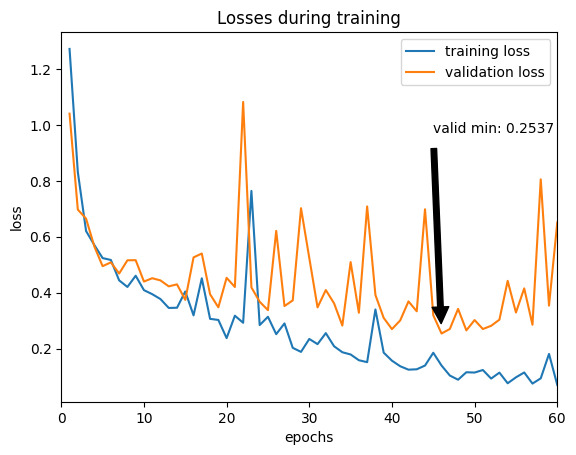

In [116]:
# See the training plot
hp.plot_checkpoint(checkpoint)

In [117]:
# Test the model
accuracy, test_loss, outputs = hp.do_test(model, loaders, criterion)
print('Accuracy: {:.2f}'.format(accuracy))

Accuracy: 0.93


In [118]:
# Release memory on the GPU
del model, optimizer
torch.cuda.empty_cache()

## Transfer learning

The model tested above does quite well when it comes to identifying the different types of images. Note that this _dataset_ is more complicated than the MNIST one. As the complexity of the dataset increases, it is common to use more complex models. In pytorch we have a series of pre-trained models on hundreds of thousands of images. These models can be used with little modification to extract parameters in other _datasets_.

In these cases, these pretrained models already extract endless patterns from their convolutional layers. The only thing we will do is replace the classifier with our custom classifierown that, obviously, has as many outputs as different classes to distinguis between. Thus, during training, only the classifier will be trained, leaving the weights from the convolutional layers as they come in the pretrained model.

In the next cell a pre-trained model will be loaded. In this case we choose the VGG16; but it is not the only one available nor does it is necessarily the best.

See the documentation for the pre-trained models available at: [https://pytorch.org/vision/stable/models.html](https://pytorch.org/vision/stable/models.html)

Information about VGG can be seen at: [arxiv.org](https://arxiv.org/abs/1409.1556)

In [119]:
# Set seed for reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)

In [120]:
# Load the pretrained model
model_transfer = models.vgg16(pretrained=True)

# Let's have a look to it
print(model_transfer)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:26<00:00, 20.8MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [121]:
# Notice that the model is made up of three parts. The first one (features) is
# where you will find all the convolution, relus and maxpool layers. The second
# (avgpool) is an adaptation block. The last one (classifier) is the one we want
# to modify
print(model_transfer.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


In [122]:
# As you can see, the classifier is nothing more than a small network of dense
# layers and relu activations, with their intermediate dropout layers.
# An important parameter is the number of inputs to the classifier (to the
# first layer)
n_inputs_cls = model_transfer.classifier[0].in_features
print(n_inputs_cls)

25088


In [123]:
# Another important parameter is the number of outputs.
# In this case this value is equal to 1000 because the VGG network is capable
# of classifying 1000 different categories; but for the use we want to give it
# we only need 4
n_outputs_cls = 4

In [124]:
# As said before, during training we want only the classifier to vary, so the
# computation of the gradients in the features block is frozen
for param in model_transfer.features.parameters():
    param.requires_grad = False

In [125]:
# And now a new classifier is built. This is just an example.
custom_cls = nn.Sequential(nn.Linear(n_inputs_cls, 512, bias=True),
                           nn.ReLU(inplace=True),
                           nn.Dropout(0.3, inplace=False),
                           nn.Linear(512, n_outputs_cls, bias=True))

In [126]:
# The new classifier you have defined has the parameters with the requires_grad
# attribute on by default.
print(custom_cls[0].weight.requires_grad)

True


In [127]:
# Therefore, we have only to insert the new classifier in the model
model_transfer.classifier = custom_cls
print(model_transfer.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=512, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=512, out_features=4, bias=True)
)


In [128]:
# Transfer the model to GPU
model_transfer.to(DEVICE)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

The training will then be performed using the `train()` helper function. Note that this function records the _state_dict_ of the entire model, and that the model consists of a pretrained part and a custom classifier. Keep this in mind because if you wanted to load the saved model, you would have to import the pretrained model as we did before, initialize your custom classifier with its particular structure, put the classifier in the model, and then finally load the saved _state_dict_ .

In [129]:
# The name of the model done by transfer learning
FILENAME = 'pr4_transfer_model.pt'

In [130]:
# The optimizer
optimizer = torch.optim.SGD(model_transfer.parameters(), lr=0.04)

In [131]:
# Remember that we have not put a LogSoftmax layer at the output of the
# classifier, so we will have to use CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

In [132]:
# Do the training
n_epochs = 30
model_transfer, tr_data = hp.train(n_epochs, loaders, model_transfer, optimizer,
                                   criterion, FILENAME)

Epoch: 1 	Training loss: 0.74924 	Validation loss: 0.25314            	 Time: 12.6 s
Checkpoint saved at epoch 1
Epoch: 2 	Training loss: 0.21679 	Validation loss: 0.15866            	 Time: 13.1 s
Checkpoint saved at epoch 2
Epoch: 3 	Training loss: 0.13313 	Validation loss: 0.27841            	 Time: 13.3 s
Epoch: 4 	Training loss: 0.12591 	Validation loss: 0.13681            	 Time: 12.7 s
Checkpoint saved at epoch 4
Epoch: 5 	Training loss: 0.07987 	Validation loss: 0.13169            	 Time: 13.0 s
Checkpoint saved at epoch 5
Epoch: 6 	Training loss: 0.06406 	Validation loss: 0.10771            	 Time: 13.3 s
Checkpoint saved at epoch 6
Epoch: 7 	Training loss: 0.05137 	Validation loss: 0.13733            	 Time: 13.0 s
Epoch: 8 	Training loss: 0.05333 	Validation loss: 0.15040            	 Time: 11.6 s
Epoch: 9 	Training loss: 0.05624 	Validation loss: 0.09590            	 Time: 12.3 s
Checkpoint saved at epoch 9
Epoch: 10 	Training loss: 0.02725 	Validation loss: 0.09264        

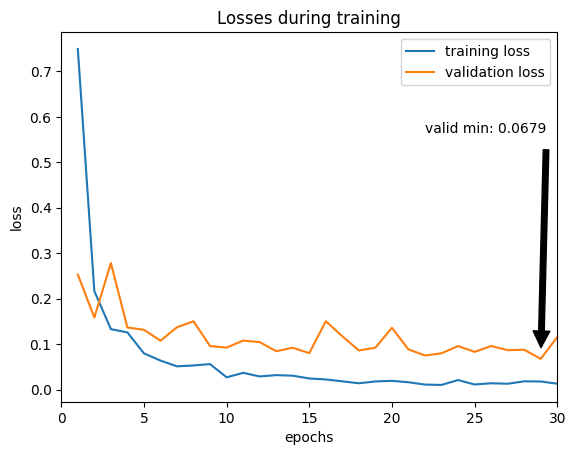

In [133]:
# Training and validation plots
hp.plot_checkpoint({'tr_loss_list': tr_data[0], 'vl_loss_list': tr_data[1]})

In [134]:
# Test the model
accuracy, test_loss, outputs = hp.do_test(model_transfer, loaders, criterion)
print('Accuracy: {:.2f}'.format(accuracy))

Accuracy: 0.98
